# Chapter 6:

## Graph Convolutional Networks:

### With Cora dataset:

In [1]:
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import degree
from collections import Counter
import matplotlib.pyplot as plt

dataset = Planetoid(root=".", name="Cora")
data = dataset[0]

/home/didiersalest/GNN_Book/GNN_Practice/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
degrees = degree(data.edge_index[0]).numpy()
degrees

array([3., 3., 5., ..., 1., 4., 4.], dtype=float32)

In [6]:
numbers = Counter(degrees)
numbers

Counter({3.0: 553,
         5.0: 281,
         1.0: 485,
         4.0: 389,
         2.0: 583,
         7.0: 82,
         6.0: 131,
         9.0: 25,
         8.0: 57,
         12.0: 18,
         10.0: 26,
         36.0: 1,
         11.0: 14,
         21.0: 3,
         32.0: 2,
         19.0: 5,
         13.0: 5,
         78.0: 1,
         17.0: 8,
         14.0: 6,
         16.0: 7,
         18.0: 3,
         15.0: 6,
         33.0: 1,
         29.0: 1,
         34.0: 1,
         23.0: 3,
         30.0: 2,
         26.0: 1,
         168.0: 1,
         22.0: 1,
         42.0: 1,
         74.0: 1,
         44.0: 1,
         31.0: 1,
         65.0: 1,
         40.0: 1})

<BarContainer object of 37 artists>

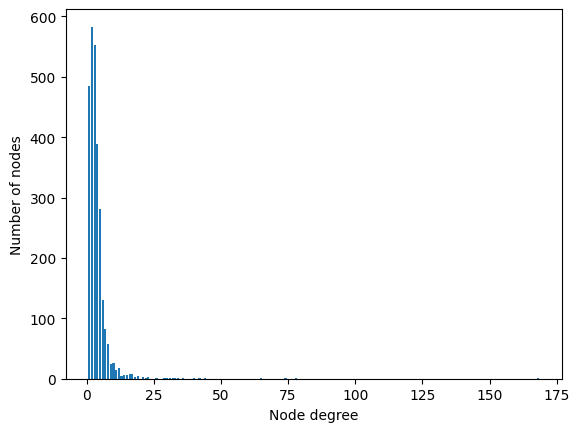

In [8]:
fig, ax = plt.subplots()
ax.set_xlabel('Node degree')
ax.set_ylabel('Number of nodes')
plt.bar(numbers.keys(), numbers.values())

<BarContainer object of 37 artists>

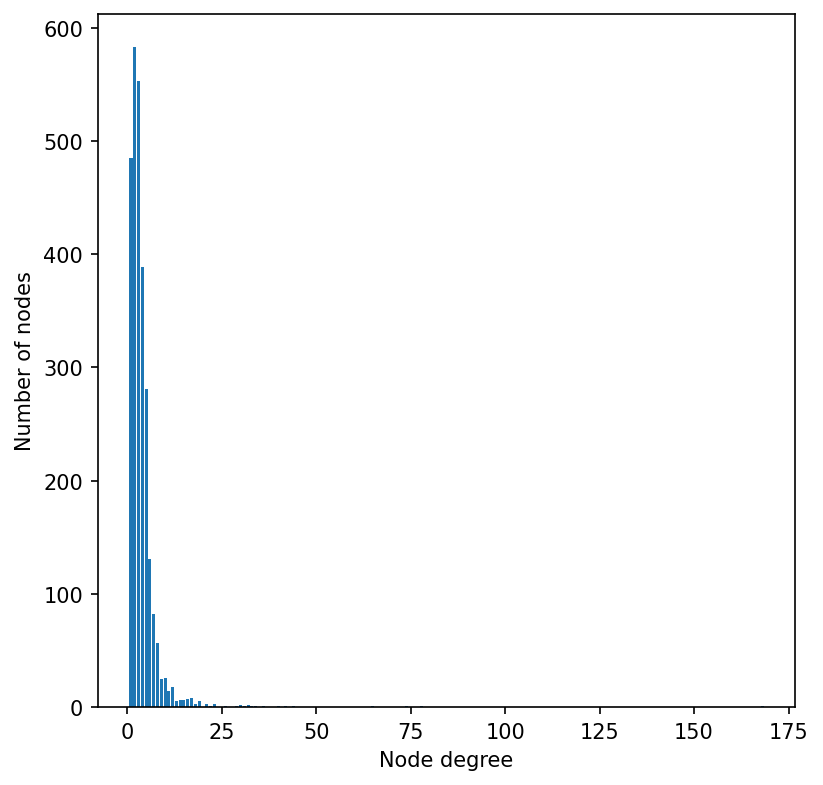

In [11]:
plt.figure(figsize=[6,6], dpi=150)
plt.xlabel("Node degree")
plt.ylabel("Number of nodes")
plt.bar(numbers.keys(), numbers.values())

### With Custom Facebook Page to Page Dataset

In [12]:
# Facebook Page to Page Manual Loading:

from typing import Callable, Optional
import kagglehub
import numpy as np
import torch
import pandas as pd
import json
from torch_geometric.data import Data, InMemoryDataset, download_url
from torch_geometric.utils import to_undirected
from sklearn.decomposition import PCA


class ManualFacebookPagePage(InMemoryDataset):
    r"""The Facebook Page-Page network dataset introduced in the
    `"Multi-scale Attributed Node Embedding"
    <https://arxiv.org/abs/1909.13021>`_ paper.
    Nodes represent verified pages on Facebook and edges are mutual likes.
    It contains 22,470 nodes, 342,004 edges, 128 node features and 4 classes.

    Args:
        root (str): Root directory where the dataset should be saved.
        transform (callable, optional): A function/transform that takes in an
            :obj:`torch_geometric.data.Data` object and returns a transformed
            version. The data object will be transformed before every access.
            (default: :obj:`None`)
        pre_transform (callable, optional): A function/transform that takes in
            an :obj:`torch_geometric.data.Data` object and returns a
            transformed version. The data object will be transformed before
            being saved to disk. (default: :obj:`None`)
    """

    url = 'https://www.kaggle.com/api/v1/datasets/download/ishandutta/facebook-large-pagepage-network-data-set'

    dataset_path = ""

    def __init__(
        self,
        root: str,
        transform: Optional[Callable] = None,
        pre_transform: Optional[Callable] = None,
    ) -> None:
        super().__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self) -> str:
        return [f'{self.dataset_path}/facebook_large/musae_facebook_edges.csv', f'{self.dataset_path}/facebook_large/musae_facebook_features.json', f'{self.dataset_path}/facebook_large/musae_facebook_target.csv']

    @property
    def processed_file_names(self) -> str:
        return 'data.pt'

    def download(self) -> None:
        path = kagglehub.dataset_download("ishandutta/facebook-large-pagepage-network-data-set")
        self.dataset_path=path
        print(f"Path to downloaded dataset: {path}")

    def process(self) -> None:
        fb_p2p_edges = pd.read_csv(self.raw_paths[0])
        edge_values = np.array(fb_p2p_edges[['id_1', 'id_2']].values.tolist())
        edge_index = torch.from_numpy(edge_values).to(torch.long)
        edge_index = edge_index.t().contiguous()
        edge_index = to_undirected(edge_index)

        with open(self.raw_paths[1], "r") as f:
            fb_p2p_features = json.load(f)
        fb_p2p_features_df = pd.DataFrame({int(key): value for key, value in fb_p2p_features.items()}.items(), columns=['id', 'features'])
        fb_p2p_features_df = fb_p2p_features_df.sort_values(by="id", ascending=True, ignore_index=True)

        fb_p2p_target = pd.read_csv(self.raw_paths[2])

        merged_data = fb_p2p_target.merge(fb_p2p_features_df, on="id")

        merged_data['features'] = merged_data['features'].apply(lambda row: np.array(row))
        
        num_nodes = len(merged_data)

        all_features = [feat for feature_list in merged_data['features'] for feat in feature_list]
        num_features = max(all_features) + 1

        print(num_features)

        indices = [[i, feat] for i, feature_list in enumerate(merged_data['features']) for feat in feature_list]
        values = [1.0] * len(indices)
        x_sparse = torch.sparse_coo_tensor(torch.tensor(indices).t(), values, (num_nodes, num_features))
        
        # Convert to a dense tensor for PCA
        x_dense_numpy = x_sparse.to_dense().numpy()

        print(f"Original feature shape: {x_dense_numpy.shape}")

        # Initialize PCA to reduce the features to 128 dimensions
        pca = PCA(n_components=128)

        # Fit PCA on the data and transform it
        x_pca = pca.fit_transform(x_dense_numpy)

        print(f"New feature shape after PCA: {x_pca.shape}")

        # Convert the resulting NumPy array back to a PyTorch tensor
        x = torch.from_numpy(x_pca).to(torch.float)

        num_targets = 4

        print(num_targets)

        target_map = {"tvshow": 0, "government": 1, "company": 2, "politician": 3}

        y_values = merged_data['page_type'].map(target_map).values
        y = torch.from_numpy(y_values).to(torch.long)

        data = Data(x=x, y=y, edge_index=edge_index)

        if self.pre_transform is not None:
            data = self.pre_transform(data)

        torch.save(self.collate([data]), self.processed_paths[0])

In [14]:
dataset = ManualFacebookPagePage(root=".")
data = dataset[0]

Path to downloaded dataset: /home/didiersalest/.cache/kagglehub/datasets/ishandutta/facebook-large-pagepage-network-data-set/versions/1


In [19]:
degrees = degree(data.edge_index[0]).numpy()
numbers = Counter(degrees)
numbers

Counter({1.0: 2658,
         34.0: 100,
         12.0: 490,
         10.0: 621,
         51.0: 53,
         22.0: 228,
         16.0: 333,
         3.0: 1850,
         2.0: 2322,
         4.0: 1509,
         6.0: 1114,
         17.0: 349,
         55.0: 36,
         38.0: 85,
         13.0: 453,
         28.0: 146,
         5.0: 1360,
         30.0: 127,
         15.0: 379,
         43.0: 78,
         18.0: 316,
         23.0: 214,
         59.0: 38,
         9.0: 729,
         31.0: 133,
         20.0: 263,
         11.0: 552,
         94.0: 12,
         8.0: 813,
         19.0: 264,
         25.0: 198,
         7.0: 965,
         29.0: 149,
         47.0: 51,
         49.0: 44,
         48.0: 53,
         32.0: 112,
         45.0: 59,
         58.0: 27,
         46.0: 49,
         14.0: 390,
         27.0: 149,
         71.0: 20,
         26.0: 192,
         21.0: 232,
         60.0: 38,
         56.0: 36,
         33.0: 131,
         142.0: 4,
         35.0: 108,
         134.0: 3,


<BarContainer object of 234 artists>

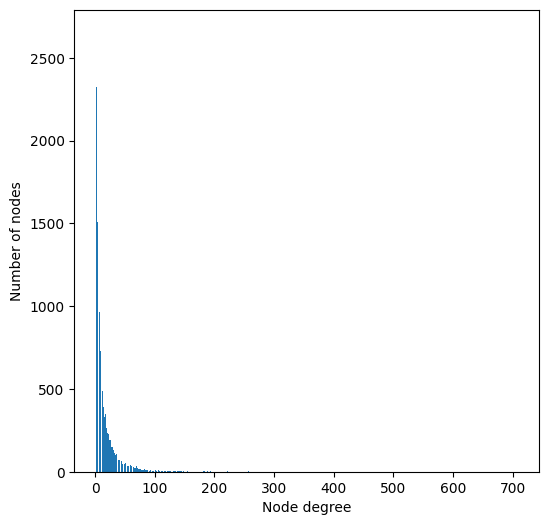

In [17]:
plt.figure(figsize=[6,6])
plt.xlabel("Node degree")
plt.ylabel("Number of nodes")
plt.bar(numbers.keys(), numbers.values())

<BarContainer object of 234 artists>

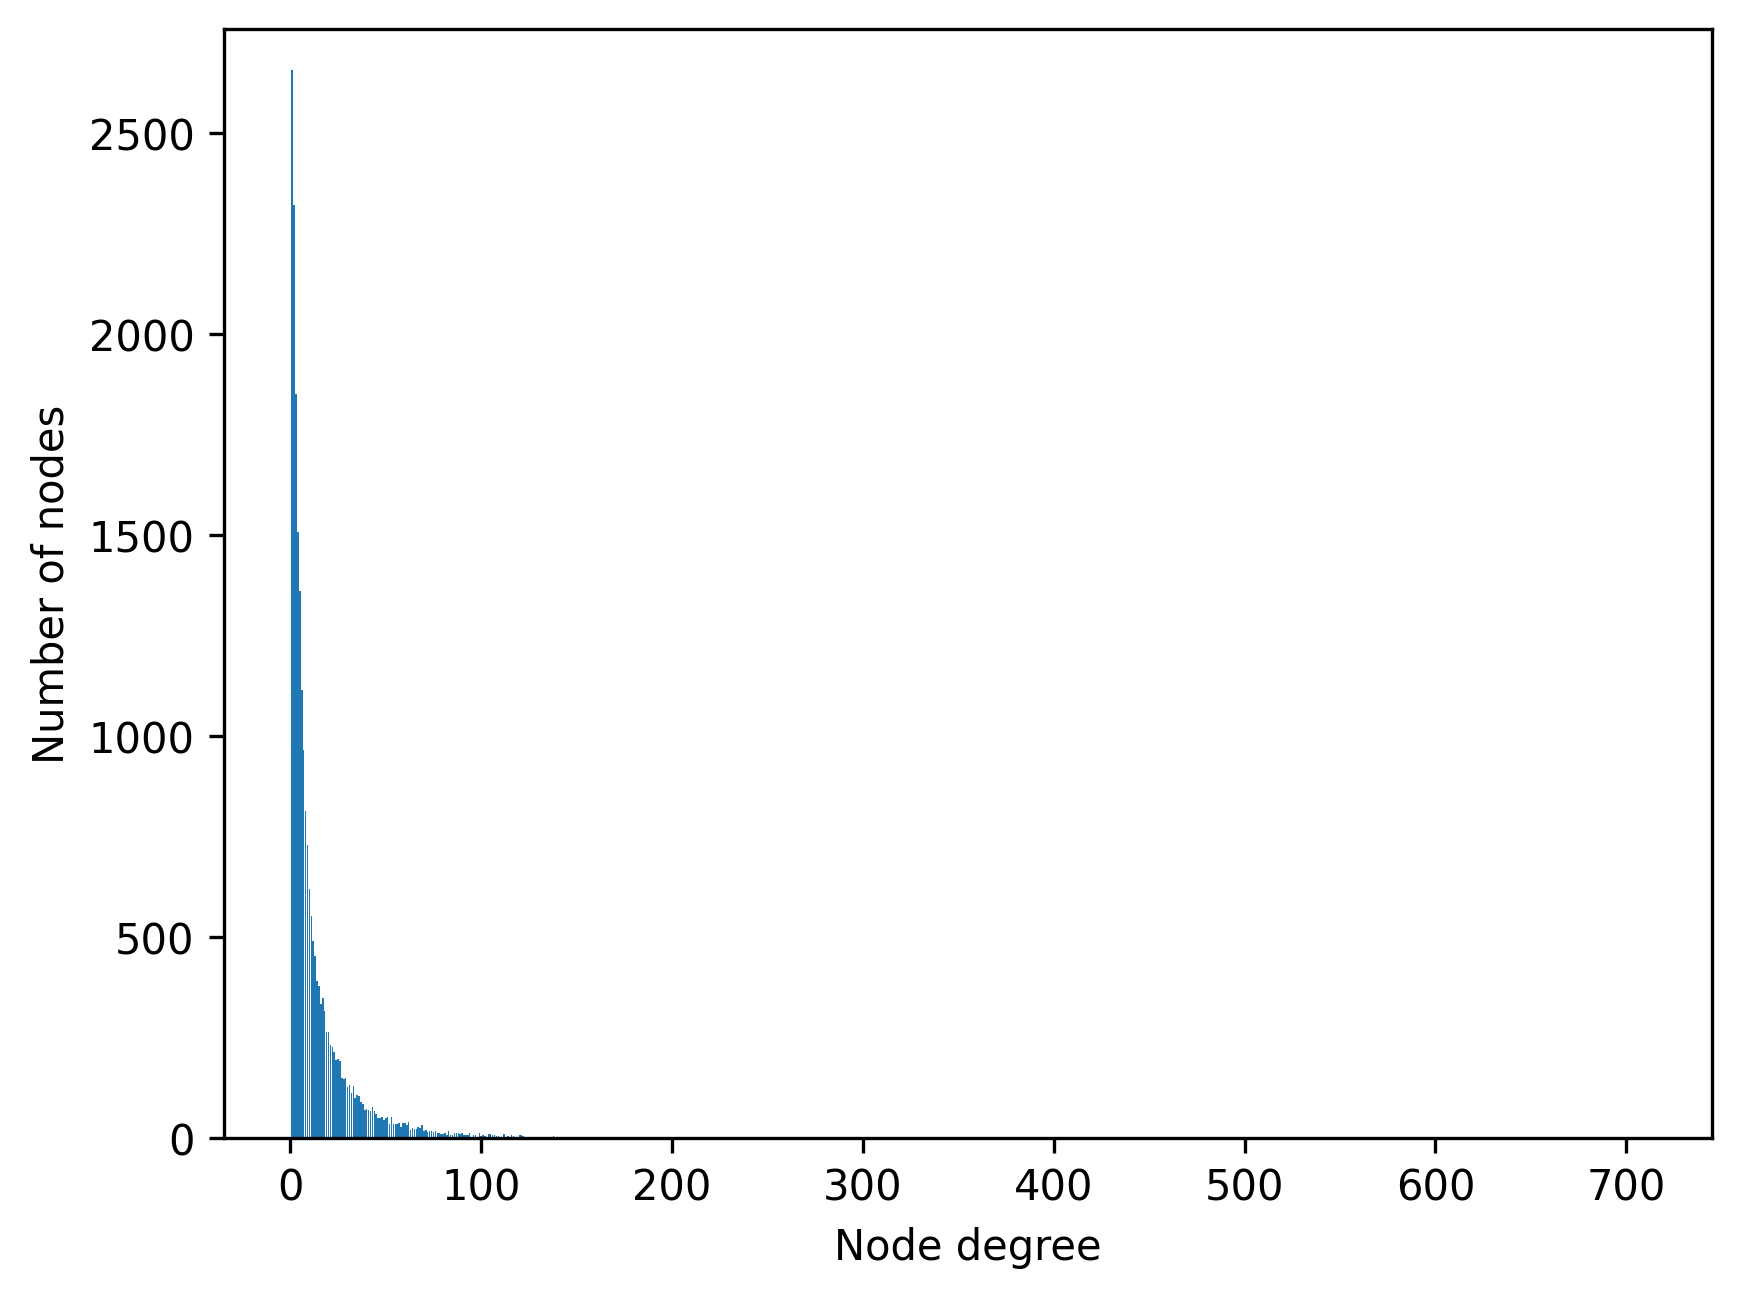

In [24]:
fig, ax = plt.subplots()
fig.dpi=300
ax.set_xlabel('Node degree')
ax.set_ylabel('Number of nodes')
ax.set_ylim(top=max(numbers.values())+100)
plt.bar(numbers.keys(), numbers.values())

### Implementing GCN:

In [25]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

In [26]:
def accuracy(pred_y, y):
    return ((pred_y==y).sum()/len(y)).item()

In [41]:
class GCN(torch.nn.Module):
    def __init__(self, dim_in, dim_h, dim_out):
        super().__init__()
        self.gcn1 = GCNConv(dim_in, dim_h)
        self.gcn2 = GCNConv(dim_h, dim_out)
    
    def forward(self, x, edge_index):
        h = self.gcn1(x, edge_index)
        h = torch.relu(h)
        h = self.gcn2(h, edge_index)
        return F.log_softmax(h, dim=1)
    
    def fit(self, data, epochs):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr = 0.01, weight_decay=5e-4)

        self.train()

        for epoch in range(epochs+1):
            optimizer.zero_grad()
            out = self(data.x, data.edge_index)
            loss = criterion(out[data.train_mask], data.y[data.train_mask])

            acc = accuracy(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
            loss.backward()
            optimizer.step()

            if (epoch % 20 == 0):
                val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
                val_acc = accuracy(out[data.val_mask].argmax(dim=1), data.y[data.val_mask])

                print(f"Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: {acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | Val Acc: {val_acc*100:.2f}%")
    
    def test(self, data):
        self.eval()
        out = self(data.x, data.edge_index)
        acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
        return acc

### With Custom Facebook Page-to-Page Dataset:

In [42]:
dataset = ManualFacebookPagePage(root=".")
data = dataset[0]
data.train_mask = range(18000)
data.val_mask = range(18001, 20000)
data.test_mask = range(20001, 22470)

Path to downloaded dataset: /home/didiersalest/.cache/kagglehub/datasets/ishandutta/facebook-large-pagepage-network-data-set/versions/1


In [43]:
gcn = GCN(dataset.num_features, 16, dataset.num_classes)
print(gcn)
gcn.fit(data, epochs=100)

GCN(
  (gcn1): GCNConv(128, 16)
  (gcn2): GCNConv(16, 4)
)
Epoch   0 | Train Loss: 1.414 | Train Acc: 22.60% | Val Loss: 1.42 | Val Acc: 21.91%
Epoch  20 | Train Loss: 0.921 | Train Acc: 67.88% | Val Loss: 0.92 | Val Acc: 68.08%
Epoch  40 | Train Loss: 0.569 | Train Acc: 82.54% | Val Loss: 0.57 | Val Acc: 82.14%
Epoch  60 | Train Loss: 0.390 | Train Acc: 88.29% | Val Loss: 0.39 | Val Acc: 88.84%
Epoch  80 | Train Loss: 0.324 | Train Acc: 90.12% | Val Loss: 0.32 | Val Acc: 90.30%
Epoch 100 | Train Loss: 0.298 | Train Acc: 91.01% | Val Loss: 0.29 | Val Acc: 90.90%


In [44]:
acc = gcn.test(data)
print(f"GCN Test Accuracy: {acc*100:.2f}%")

GCN Test Accuracy: 90.36%


### With Cora dataset:

In [45]:
import torch_geometric.transforms as T
dataset = Planetoid(root=".", name="Cora")
data = dataset[0]

In [46]:
gcn = GCN(dataset.num_features, 16, dataset.num_classes)
print(gcn)
gcn.fit(data, epochs=100)

GCN(
  (gcn1): GCNConv(1433, 16)
  (gcn2): GCNConv(16, 7)
)
Epoch   0 | Train Loss: 1.950 | Train Acc: 12.86% | Val Loss: 1.95 | Val Acc: 12.60%
Epoch  20 | Train Loss: 0.123 | Train Acc: 100.00% | Val Loss: 0.80 | Val Acc: 77.20%
Epoch  40 | Train Loss: 0.016 | Train Acc: 100.00% | Val Loss: 0.75 | Val Acc: 77.20%
Epoch  60 | Train Loss: 0.015 | Train Acc: 100.00% | Val Loss: 0.73 | Val Acc: 77.80%
Epoch  80 | Train Loss: 0.018 | Train Acc: 100.00% | Val Loss: 0.72 | Val Acc: 78.00%
Epoch 100 | Train Loss: 0.016 | Train Acc: 100.00% | Val Loss: 0.72 | Val Acc: 77.40%


In [47]:
acc = gcn.test(data)
print(f"GCN Test Accuracy: {acc*100:.2f}%")

GCN Test Accuracy: 80.60%


## Predicting web traffic with node regression

In [33]:
from torch_geometric.datasets import WikipediaNetwork
import torch_geometric.transforms as T
transform = T.RandomNodeSplit(num_val=200, num_test=500)
dataset = WikipediaNetwork(root=".", name="chameleon")

data = transform(dataset[0])
data

Data(x=[2277, 2325], edge_index=[2, 36101], y=[2277], train_mask=[2277], val_mask=[2277], test_mask=[2277])

In [34]:
print(f"Dataset: {dataset}")
print("-------------------")
print(f"Number of graphs: {len(dataset)}")
print(f"Number of nodes: {data.x.shape[0]}")
print(f"Number of features: {dataset.num_features}")
print(f"Number of classes: {dataset.num_classes}") # need to be updated with continous values
print(f"Graph:")
print("-------")
print(f"Edges are directed: {data.is_directed()}")
print(f"Graph has isolated nodes: {data.has_isolated_nodes()}")
print(f"Graph has loops: {data.has_self_loops()}")

Dataset: WikipediaNetwork()
-------------------
Number of graphs: 1
Number of nodes: 2277
Number of features: 2325
Number of classes: 5
Graph:
-------
Edges are directed: True
Graph has isolated nodes: False
Graph has loops: True


In [35]:
import pandas as pd  
import torch
import numpy as np

df = pd.read_csv("wikipedia/chameleon/musae_chameleon_target.csv")
values = np.log10(df["target"])
data.y = torch.tensor(values)
data.y

tensor([2.2330, 3.9079, 3.9329,  ..., 1.9956, 4.3598, 2.4409],
       dtype=torch.float64)

/tmp/ipykernel_150553/3558600065.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df["target"], fit=norm)


<AxesSubplot: xlabel='target', ylabel='Density'>

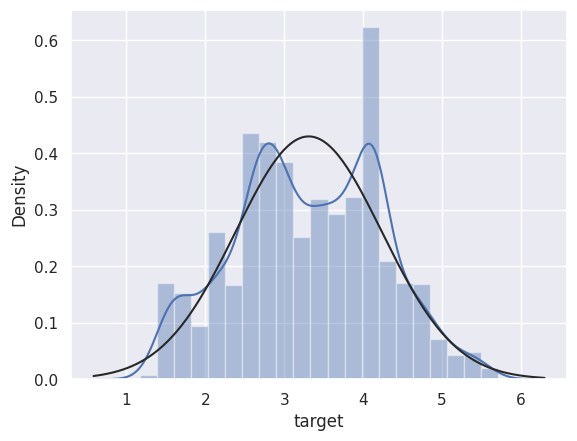

In [36]:
import seaborn as sns
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_theme()
df["target"]= values
sns.distplot(df["target"], fit=norm)

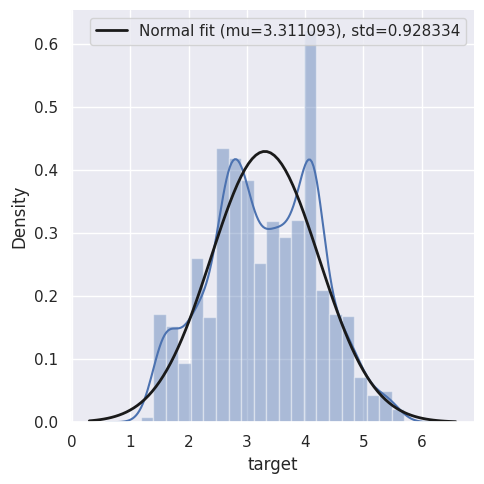

In [37]:
fig = sns.displot(df, x="target", stat="density", kde=True, kde_kws=dict(cut=3), alpha=.4, edgecolor=(1,1,1,.4))
ax2 = fig.ax
mu2, std2 = norm.fit(df["target"])
xmin2, xmax2 = ax2.get_xlim()
x2 = np.linspace(xmin2, xmax2, 100)
p2 = norm.pdf(x2, mu2, std2)
ax2.plot(x2, p2, "k", linewidth=2, label=f"Normal fit (mu={mu2:2f}), std={std2:2f}")
ax2.legend()


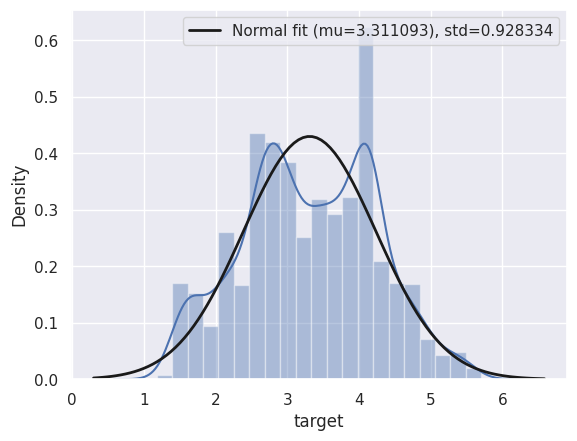

In [38]:
axes = sns.histplot(df, x="target", stat="density", kde=True, kde_kws=dict(cut=3), alpha=.4, edgecolor=(1,1,1,.4))
ax2 = axes
mu2, std2 = norm.fit(df["target"])
xmin2, xmax2 = ax2.get_xlim()
x2 = np.linspace(xmin2, xmax2, 100)
p2 = norm.pdf(x2, mu2, std2)
ax2.plot(x2, p2, "k", linewidth=2, label=f"Normal fit (mu={mu2:2f}), std={std2:2f}")
ax2.legend()


In [39]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
class GCN(torch.nn.Module):
    def __init__(self, dim_in, dim_h, dim_out):
        super().__init__()
        self.gcn1 = GCNConv(dim_in, dim_h*4)
        self.gcn2 = GCNConv(dim_h*4, dim_h*2)
        self.gcn3 = GCNConv(dim_h*2, dim_h)
        self.linear = torch.nn.Linear(dim_h, dim_out)
    
    def forward(self, x, edge_index):
        h = self.gcn1(x, edge_index)
        h = torch.relu(h)
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.gcn2(h, edge_index)
        h = torch.relu(h)
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.gcn3(h, edge_index)
        h = torch.relu(h)
        h = self.linear(h)
        return h
    def fit(self, data, epochs):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.02, weight_decay=5e-4)
        self.train()
        for epoch in range(epochs+1):
            optimizer.zero_grad()
            out = self(data.x, data.edge_index)
            loss = F.mse_loss(out.squeeze()[data.train_mask], data.y[data.train_mask].float())
            loss.backward()
            optimizer.step()
            if epoch % 20 == 0:
                val_loss = F.mse_loss(out.squeeze()[data.val_mask], data.y[data.val_mask].float())
                print(f"Epoch {epoch:>3} | Train Loss: {loss:.5f} | Val Loss: {val_loss:.5f}")
    
    @torch.no_grad()
    def test(self, data):
        self.eval()
        out = self(data.x, data.edge_index)
        return F.mse_loss(out.squeeze()[data.test_mask], data.y[data.test_mask].float())

In [40]:
gcn = GCN(dataset.num_features, 128, 1)
print(gcn)
gcn.fit(data, epochs = 200)

GCN(
  (gcn1): GCNConv(2325, 512)
  (gcn2): GCNConv(512, 256)
  (gcn3): GCNConv(256, 128)
  (linear): Linear(in_features=128, out_features=1, bias=True)
)
Epoch   0 | Train Loss: 12.41787 | Val Loss: 13.20318
Epoch  20 | Train Loss: 10.91236 | Val Loss: 11.68280
Epoch  40 | Train Loss: 4.34330 | Val Loss: 5.18078
Epoch  60 | Train Loss: 0.78768 | Val Loss: 1.05211
Epoch  80 | Train Loss: 0.57268 | Val Loss: 0.83298
Epoch 100 | Train Loss: 0.45066 | Val Loss: 0.85200
Epoch 120 | Train Loss: 0.40387 | Val Loss: 0.86129
Epoch 140 | Train Loss: 0.37686 | Val Loss: 0.82221
Epoch 160 | Train Loss: 0.33918 | Val Loss: 0.74611
Epoch 180 | Train Loss: 0.33050 | Val Loss: 0.74026
Epoch 200 | Train Loss: 0.29641 | Val Loss: 0.67008


In [41]:
loss = gcn.test(data)
print(f"GCN test loss: {loss:.5f}")

GCN test loss: 0.65002


In [44]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

out = gcn(data.x, data.edge_index)
y_pred = out.squeeze()[data.test_mask].detach().numpy()
mse = mean_squared_error(data.y[data.test_mask], y_pred)
mae = mean_absolute_error(data.y[data.test_mask], y_pred)

In [45]:
print("="*43)
print(f"MSE = {mse:.4f} | RMSE = {np.sqrt(mse):.4f} | MAE = {mae:.4f}")
print("="*43)

MSE = 0.6500 | RMSE = 0.8062 | MAE = 0.6082


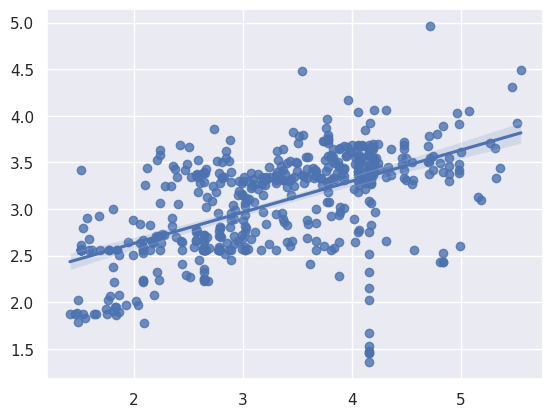

In [46]:
fig = sns.regplot(x=data.y[data.test_mask].numpy(), y=y_pred)

# Chapter 7

## Graph Attention Networks - Introducing the graph attention layer